In [1]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from app.data_ingestion.data_utils import DataUtils

sns.set()
sns.set_palette("viridis")

In [10]:
data_dir = os.path.abspath(os.path.join(".", "cs-train"))
print('data path')
print(data_dir)

data path
C:\workspace\ai-workflow-capstone\cs-train


In [ ]:
data_handler = DataUtils()
invoices_df = data_handler.load_all_json_files(data_dir)\
                          .convert_to_dataframe()

## What is the revenue per year?

Look at this chart and see the amount of revenue by year from 2017 to 2019.

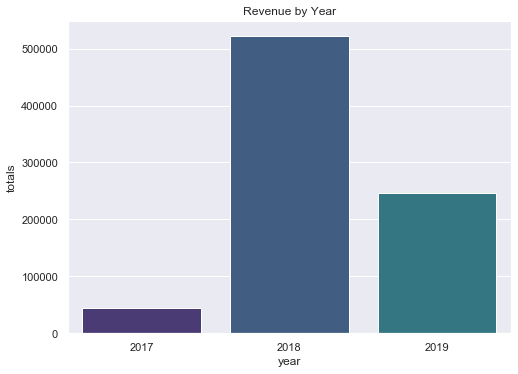

In [12]:
revenue_df_by_year = invoices_df['year']\
    .value_counts().to_frame().reset_index()
revenue_df_by_year.columns = ['year', 'totals']

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=3)
ax1.title.set_text('Revenue by Year')
sns.barplot(ax=ax1, data=revenue_df_by_year, x='year', y='totals')
fig.tight_layout(pad=3.0)
fig.show()

## Which country had the most total revenue when you summed across all purchases?

In [13]:
invoices_df_ts = data_handler.convert_dataframe_to_ts(index_column=['year', 'month', 'day'])

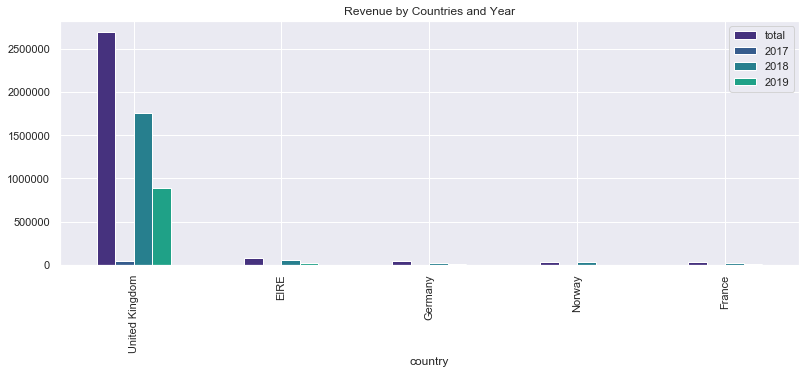

In [14]:
revenue_by_country_df = invoices_df_ts[['country', 'price']].groupby([pd.Grouper(freq='Y'), 'country'])\
                                                          .sum()\
                                                          .unstack()\
                                                          .transpose()\
                                                          .reset_index()
revenue_by_country_df.columns = ['level', 'country', '2017', '2018', '2019']
revenue_by_country_df['total'] = revenue_by_country_df['2017']\
                                  + revenue_by_country_df['2018']\
                                  + revenue_by_country_df['2019']

revenue_by_country_df.sort_values('total', ascending=False, inplace=True)

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=3)
ax1.title.set_text('Revenue by Countries and Year')
revenue_by_country_df.head().plot(x='country', y=['total', '2017', '2018', '2019'], kind="bar", ax=ax1)
fig.tight_layout(pad=3.0)
fig.show()

## When you compiled the JSON files into a single DataFrame or NumPy array, about how many days did the entire range of dates span?

In [15]:
invoices_df_ts_by_day = invoices_df_ts.resample('D').max()
print('{} unique days'.format(len(invoices_df_ts_by_day)))

611 unique days


## Missing values

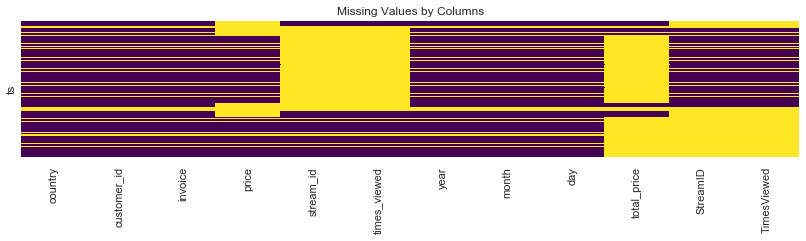

In [16]:
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.title.set_text('Missing Values by Columns')

ax = sns.heatmap(ax=ax1, data=invoices_df_ts_by_day.isnull(), yticklabels=False, cbar=False, cmap='viridis')

fig.tight_layout(pad=3.0)
fig.show()

## Revenue Time Series Decompositon

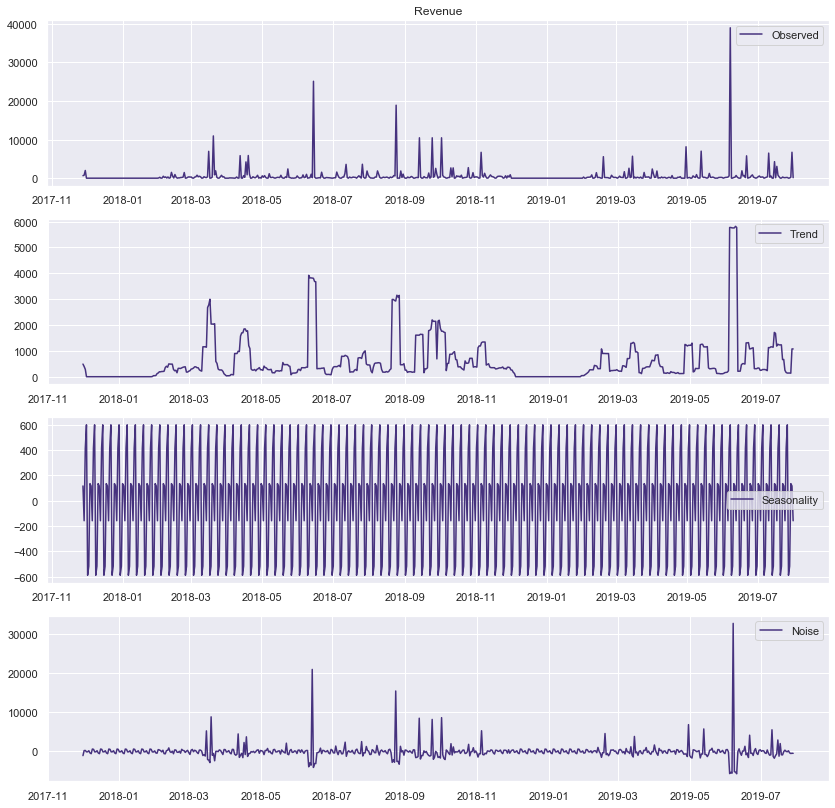

In [220]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = invoices_df_resample_day['price'].fillna(0)
decomposition = seasonal_decompose(x=ts, model='additive', ) # 1 weeks

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

plt.figure(figsize=(14,14))
plt.subplot(411)
plt.title('Revenue')
plt.plot(ts, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='best')


ax = plt.show()